In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('https://github.com/vinaysanga/Banking-Campaign-Output-Prediction/raw/master/bank-additional-full.csv', sep=';')

In [3]:
# Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The datatypes look fine, all the types are inferred correctly.

## Step 1: Data preprocessing


In [4]:
# Removing duration column
pd.set_option('display.max_columns', None)
df = df.drop('duration', axis = 1)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Also checking NaN values
for col in df.columns:
  print(f'{col}: {df[col].isna().sum()}')

age: 0
job: 0
marital: 0
education: 0
default: 0
housing: 0
loan: 0
contact: 0
month: 0
day_of_week: 0
campaign: 0
pdays: 0
previous: 0
poutcome: 0
emp.var.rate: 0
cons.price.idx: 0
cons.conf.idx: 0
euribor3m: 0
nr.employed: 0
y: 0


In [6]:
# One hot encode the categorical values
encoded_data = pd.get_dummies(df, drop_first=True)
encoded_data.head()

X = encoded_data.drop('y_yes', axis = 1)
y = encoded_data['y_yes']

## Step 2: Training the models

In [7]:
from sklearn.preprocessing import StandardScaler

def standardize_data(data):
  # Standardize the values
  scaler = StandardScaler()
  return scaler.fit_transform(data)

In [8]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, X_test, y_test, y_pred):

  # Calculate the accuracy
  accuracy = accuracy_score(y_test, y_pred)
  return f'{accuracy*100:.2f}%'

In [9]:
from sklearn.linear_model import LogisticRegressionCV

def train_lr(X_train, y_train):
  # Fit logistic regression
  log_res = LogisticRegressionCV(cv=10, random_state=11, max_iter=1000)
  log_res.fit(X_train, y_train)
  return log_res

In [10]:
from sklearn.neural_network import MLPClassifier

def train_mlp(X_train, y_train):
  # Fit MLP Classifier
  mlp = MLPClassifier(max_iter=500, random_state=11, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)
  mlp.fit(X_train, y_train)
  return mlp

## Step 3: Visualise the performance

### ROC Curve

In [11]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

def plot_roc_curve(log_res, mlp, X_test, y_test):
  # For Logistic Regression
  y_prob_lr = log_res.predict_proba(X_test)[:, 1]

  # For MLP Classifier
  y_prob_mlp = mlp.predict_proba(X_test)[:, 1]

  fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
  fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
  auc_lr = auc(fpr_lr, tpr_lr)
  auc_mlp = auc(fpr_mlp, tpr_mlp)


  plt.figure(figsize=(10, 6))
  plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
  plt.plot(fpr_mlp, tpr_mlp, label=f'MLP Classifier (AUC = {auc_mlp:.2f})')
  plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()


### Precision, Recall, F1-Score

In [12]:
from sklearn.metrics import classification_report
import seaborn as sns

def plot_metrics(y_test, y_pred_lr, y_pred_mlp):
  # Metrics for LinearRegressionCV
  metrics_lr = classification_report(y_test, y_pred_lr, output_dict=True)

  # Metrics for MLP Classifier
  metrics_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

  # Combine metrics for Logistic Regression and MLP Classifier into a single DataFrame
  combined_metrics = []
  for model_name, dataset in [('Logistic Regression', metrics_lr), ('MLP Classifier', metrics_mlp)]:
      for key, val in dataset.items():
          if key in ['0', '1']: # 0, 1 are classes here
            for metric, value in val.items():
                if metric in ['precision', 'recall', 'f1-score']:
                    combined_metrics.append({
                        'Model': model_name,
                        'Class': f'Class {key}',
                        'Metric': metric,
                        'Score': value
                    })

  combined_metrics = pd.DataFrame(combined_metrics)

  # Add a combined column for 'Model' and 'Class' to use as hue in the plot
  combined_metrics['Model_Class'] = combined_metrics['Model'] + ', ' + combined_metrics['Class']

  # Plotting the metrics
  plt.figure(figsize=(10, 6))
  sns.barplot(data=combined_metrics, x='Metric', y='Score', hue='Model_Class', errorbar=None, palette='deep')
  plt.title('Comparison of Precision, Recall, and F1-Score with Updated Data')
  plt.xlabel('Metric')
  plt.ylabel('Score')
  plt.legend(title='Model / Class', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()
  plt.show()

Logistic Regression accuracy: 90.46%%
MLP Classifier accuracy: 90.31%%


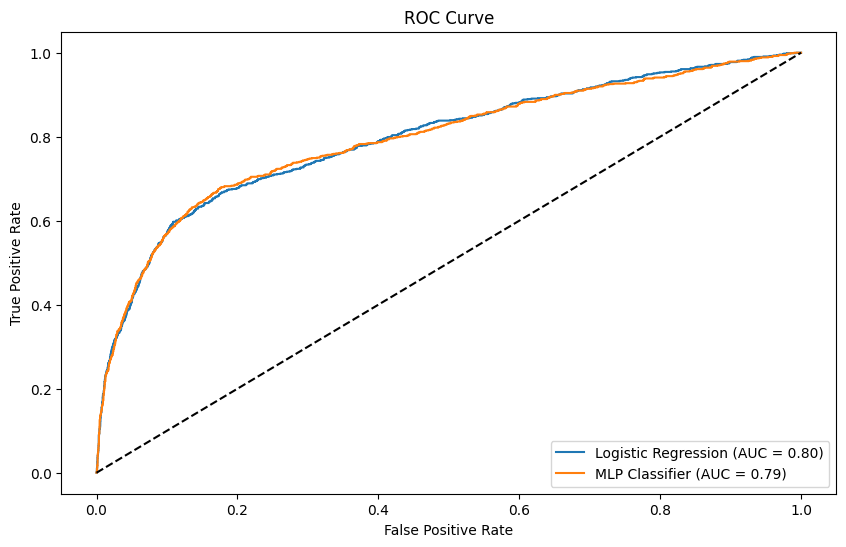

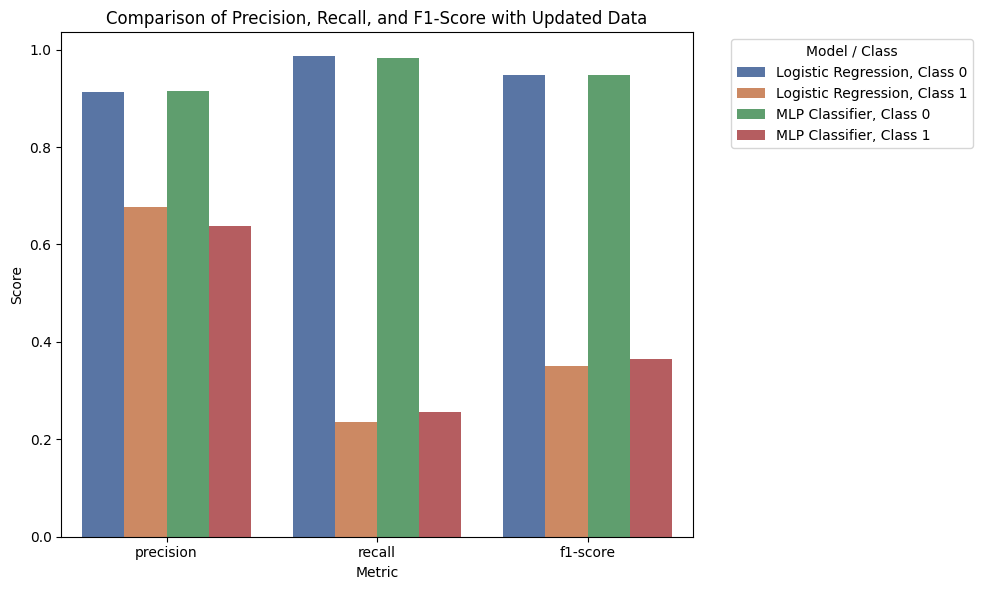

In [13]:
from sklearn.model_selection import train_test_split
def train_evaluate_models(X, y):
  # Standardize the data
  X_standardized = standardize_data(X)

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=11)

  # Train the models
  log_res = train_lr(X_train, y_train)
  mlp = train_mlp(X_train, y_train)

  # Predict the labels for the test set
  y_pred_lr = log_res.predict(X_test)
  y_pred_mlp = mlp.predict(X_test)

  # Print the accuracy
  print(f'Logistic Regression accuracy: {calculate_accuracy(log_res, X_test, y_test, y_pred_lr)}%')
  print(f'MLP Classifier accuracy: {calculate_accuracy(mlp, X_test, y_test, y_pred_mlp)}%')

  # Plot the curves
  plot_roc_curve(log_res, mlp, X_test, y_test)
  plot_metrics(y_test, y_pred_lr, y_pred_mlp)

# Driver code for LogisticRegression and MLP Classifier
train_evaluate_models(X, y)

There is good accuracy but poor precision and recall for class 1 (i.e. y = 'yes')

<ipython-input-14-1a28444157a8>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

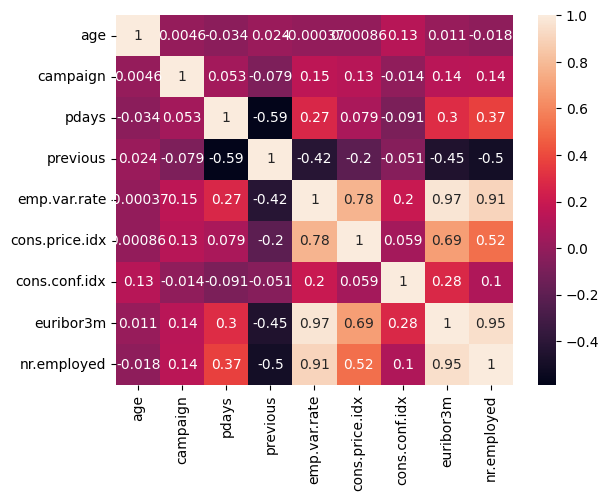

In [14]:
# First, let us remove the highly correlated features
sns.heatmap(df.corr(), annot=True)

There is a high correlation between 'cons.price.idx-emp.var.rate', 'euribor3m - emp.var.rate', 'nr.employed - emp.var.rate', 'nr.employed-euribor3m'

In [15]:
features_to_remove = ['cons.price.idx', 'euribor3m', 'nr.employed', 'emp.var.rate']
df = df.drop(features_to_remove, axis = 1)

In [16]:
# Let use check the target class distribution
df['y'].value_counts()/len(df.index) * 100

no     88.734583
yes    11.265417
Name: y, dtype: float64

There is a class imbalanced with the skewness in favour of 'no'. Let us use over sampling to mitigate this.

In [17]:
# One hot encode the categorical values
encoded_data = pd.get_dummies(df, drop_first=True)
encoded_data.head()


X = encoded_data.drop('y_yes', axis = 1)
y = encoded_data['y_yes']

In [18]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter


X = encoded_data.drop('y_yes', axis = 1)
y = encoded_data['y_yes']
print('Before resampling:')
print(sorted(Counter(y).items()))

X_resampled, y_resampled = ADASYN().fit_resample(X, y)

print('After resampling:')
print(sorted(Counter(y_resampled).items()))

Before resampling:
[(0, 36548), (1, 4640)]
After resampling:
[(0, 36548), (1, 36434)]


Logistic Regression accuracy: 85.54%%
MLP Classifier accuracy: 87.99%%


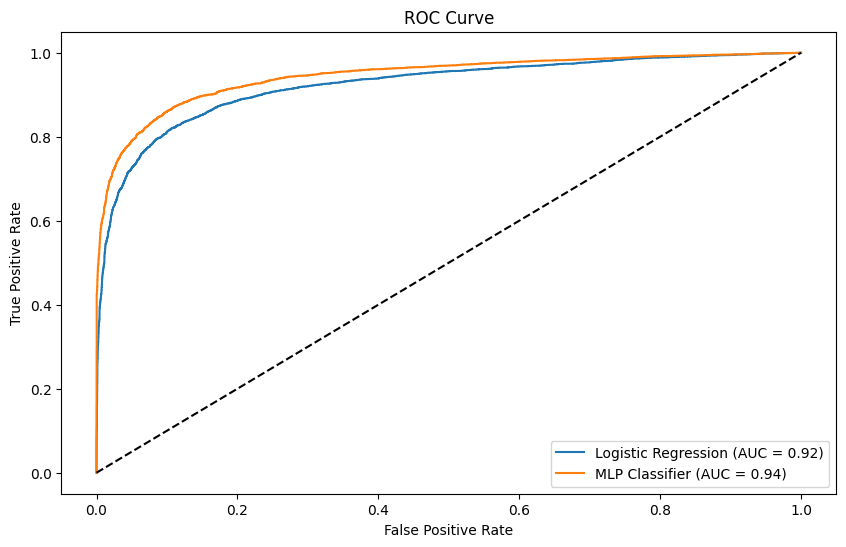

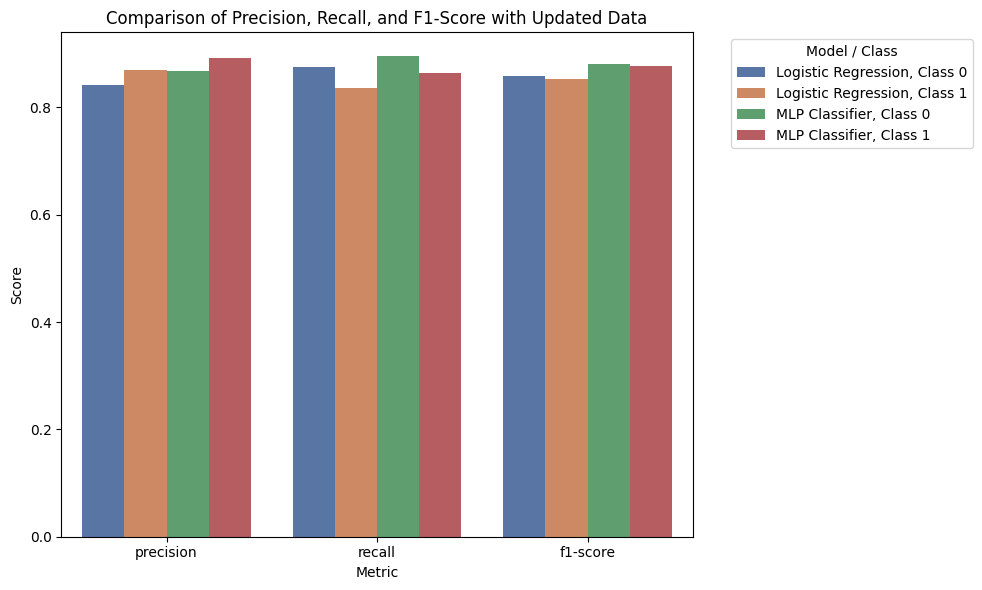

In [19]:
train_evaluate_models(X_resampled, y_resampled)

We get better precision and recall across the classes, but the accuracy is reduced. As the accuracy is above 80%, we can stop now.